# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [3]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
import copy
import gym
import torch
import random
import functools

import numpy as np
import torch.nn.functional as F

from tqdm.notebook import tqdm
from collections import deque

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for a days in period 2011-01-01 to 2019-12-31 (9 years);

In [5]:
# TOP_BRL = [
#     "ITUB4.SA", "BBDC4.SA", "VALE3.SA", "PETR4.SA", "ABEV3.SA",
#     "BBAS3.SA"
# ]

TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [6]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2019-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (22330, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.540226,576145,ABEV3.SA,0
1,2011-01-03,31.500000,31.799999,31.379999,13.811690,3313400,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.802567,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.668523,10014663,ITUB4.SA,0
4,2011-01-03,9.264964,9.492898,9.264964,7.161459,3320493,LREN3.SA,0
...,...,...,...,...,...,...,...,...
22325,2019-12-30,30.549999,30.709999,30.150000,11.973796,22111600,PETR4.SA,0
22326,2019-12-30,6.780000,6.832000,6.570000,6.612000,8933500,PRIO3.SA,0
22327,2019-12-30,47.959999,48.290001,47.299999,45.060959,2701600,RENT3.SA,0
22328,2019-12-30,53.650002,53.860001,53.200001,38.828598,11928100,VALE3.SA,0


In [7]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2233,2233,2233,2233,2233,2233,2233
BBAS3.SA,2233,2233,2233,2233,2233,2233,2233
BBDC4.SA,2233,2233,2233,2233,2233,2233,2233
ITUB4.SA,2233,2233,2233,2233,2233,2233,2233
LREN3.SA,2233,2233,2233,2233,2233,2233,2233
PETR4.SA,2233,2233,2233,2233,2233,2233,2233
PRIO3.SA,2233,2233,2233,2233,2233,2233,2233
RENT3.SA,2233,2233,2233,2233,2233,2233,2233
VALE3.SA,2233,2233,2233,2233,2233,2233,2233


## Portfolio Optimization Environment

Since POE was not merged to FinRL yet, we add its code below.

In [8]:
"""From FinRL https://github.com/AI4Finance-LLC/FinRL/tree/master/finrl/env"""
import gym
import math
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from pathlib import Path

try:
    import quantstats as qs
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        """QuantStats module not found, environment can't plot results and calculate indicadors.
        This module is not installed with FinRL. Install by running one of the options:
        pip install quantstats --upgrade --no-cache-dir
        conda install -c ranaroussi quantstats
        """
        )

class PortfolioOptimizationEnv(gym.Env):
    """A portfolio allocantion environment for OpenAI gym.

    This environment simulates the interactions between an agent and the financial market
    based on data provided by a dataframe. The dataframe contains the time series of
    features defined by the user (such as closing, high and low prices) and must have
    a time and a tic column with a list of datetimes and ticker symbols respectively.
    An example of dataframe is shown below::

            date        high            low             close           tic
        0   2020-12-23  0.157414        0.127420        0.136394        ADA-USD
        1   2020-12-23  34.381519       30.074295       31.097898       BNB-USD
        2   2020-12-23  24024.490234    22802.646484    23241.345703    BTC-USD
        3   2020-12-23  0.004735        0.003640        0.003768        DOGE-USD
        4   2020-12-23  637.122803      560.364258      583.714600      ETH-USD
        ... ...         ...             ...             ...             ...

    Based on this dataframe, the environment will create an observation space that can
    be a Dict or a Box. The Box observation space is a three-dimensional array of shape
    (f, n, t), where f is the number of features, n is the number of stocks in the
    portfolio and t is the user-defined time window. If the environment is created with
    the parameter return_last_action set to True, the observation space is a Dict with
    the following keys::

        {
        "state": three-dimensional Box (f, n, t) representing the time series,
        "last_action": one-dimensional Box (n+1,) representing the portfolio weights
        }

    Note that the action space of this environment is an one-dimensional Box with size
    n + 1 because the portfolio weights must contains the weights related to all the
    stocks in the portfolio and to the remaining cash.

    Attributes:
        action_space: Action space.
        observation_space: Observation space.
        episode_length: Number of timesteps of an episode.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        initial_amount,
        order_df=True,
        return_last_action=False,
        normalize_df="by_previous_time",
        reward_scaling=1,
        comission_fee_model="trf",
        comission_fee_pct=0,
        features=["close", "high", "low"],
        valuation_feature="close",
        time_column="date",
        time_format="%Y-%m-%d",
        tic_column="tic",
        time_window=1,
        cwd="./",
        new_gym_api=False
    ):
        """Initializes environment's instance.

        Args:
            df: Dataframe with market information over a period of time.
            initial_amount: Initial amount of cash available to be invested.
            order_df: If True input dataframe is ordered by time.
            return_last_action: If True, observations also return the last performed
                action. Note that, in that case, the observation space is a Dict.
            normalize_df: Defines the normalization method applied to input dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            reward_scaling: A scaling factor to multiply the reward function. This
                factor can help training.
            comission_fee_model: Model used to simulate comission fee. Possible values
                are "trf" (for transaction remainder factor model) and "wvm" (for weights
                vector modifier model). If None, commission fees are not considered.
            comission_fee_pct: Percentage to be used in comission fee. It must be a value
                between 0 and 1.
            features: List of features to be considered in the observation space. The
                items of the list must be names of columns of the input dataframe.
            valuation_feature: Feature to be considered in the portfolio value calculation.
            time_column: Name of the dataframe's column that contain the datetimes that
                index the dataframe.
            time_format: Formatting string of time column.
            tic_name: Name of the dataframe's column that contain ticker symbols.
            time_window: Size of time window.
            cwd: Local repository in which resulting graphs will be saved.
            new_gym_api: If True, the environment will use the new gym api standard for
                step and reset methods.
        """
        # super(StockEnv, self).__init__()
        # money = 10 , scope = 1
        self._time_window = time_window
        self._time_index = time_window - 1
        self._time_column = time_column
        self._time_format = time_format
        self._tic_column = tic_column
        self._df = df
        self._initial_amount = initial_amount
        self._return_last_action = return_last_action
        self._reward_scaling = reward_scaling
        self._comission_fee_pct = comission_fee_pct
        self._comission_fee_model = comission_fee_model
        self._features = features
        self._valuation_feature = valuation_feature
        self._cwd = Path(cwd)
        self._new_gym_api = new_gym_api

        # results file
        self._results_file = self._cwd / "results" / "rl"
        self._results_file.mkdir(parents=True, exist_ok=True)

        # price variation
        self._df_price_variation = None

        # preprocess data
        self._preprocess_data(order_df, normalize_df)

        # dims and spaces
        self._tic_list = self._df[self._tic_column].unique()
        self._stock_dim = len(self._tic_list)
        action_space = 1 + self._stock_dim

        # sort datetimes and define episode length
        self._sorted_times = sorted(set(self._df[time_column]))
        self.episode_length = len(self._sorted_times) - time_window + 1

        # define action space
        self.action_space = spaces.Box(low=0, high=1, shape=(action_space,))

        # define observation state
        if self._return_last_action:
            # if  last action must be returned, a dict observation
            # is defined
            self.observation_space = spaces.Dict({
                "state": spaces.Box(
                    low=-np.inf,
                    high=np.inf,
                    shape=(
                        len(self._features),
                        self._stock_dim,
                        self._time_window
                    )
                ),
                "last_action": spaces.Box(
                    low=0, high=1, shape=(action_space,)
                )
            })
        else:
            # if information about last action is not relevant,
            # a 3D observation space is defined
            self.observation_space = spaces.Box(
                low=-np.inf,
                high=np.inf,
                shape=(
                    len(self._features),
                    self._stock_dim,
                    self._time_window
                ),
            )

        self._reset_memory()

        self._portfolio_value = self._initial_amount
        self._terminal = False

    def step(self, actions):
        """Performs a simulation step.

        Args:
            actions: An unidimensional array containing the new portfolio
                weights.

        Note:
            If the environment was created with "return_last_action" set to
            True, the next state returned will be a Dict. If it's set to False,
            the next state will be a Box. You can check the observation state
            through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, reward, terminal, truncated, info). If it's set to False,
            the following tuple is returned: (state, reward, terminal, info).

            state: Next simulation state.
            reward: Reward related to the last performed action.
            terminal: If True, the environment is in a terminal state.
            truncated: If True, the environment has passed it's simulation
                time limit. Currently, it's always False.
            info: A dictionary containing informations about the last state.
        """
        self._terminal = self._time_index >= len(self._sorted_times) - 1

        if self._terminal:
            metrics_df = pd.DataFrame(
                {"date": self._date_memory,
                 "returns": self._portfolio_return_memory,
                 "rewards": self._portfolio_reward_memory,
                 "portfolio_values": self._asset_memory["final"]}
            )
            metrics_df.set_index("date", inplace=True)

            plt.plot(metrics_df["portfolio_values"], "r")
            plt.title("Portfolio Value Over Time")
            plt.xlabel("Time")
            plt.ylabel("Portfolio value")
            plt.savefig(self._results_file / "portfolio_value.png")
            plt.close()

            plt.plot(self._portfolio_reward_memory, "r")
            plt.title("Reward Over Time")
            plt.xlabel("Time")
            plt.ylabel("Reward")
            plt.savefig(self._results_file / "reward.png")
            plt.close()

            plt.plot(self._actions_memory)
            plt.title("Actions performed")
            plt.xlabel("Time")
            plt.ylabel("Weight")
            plt.savefig(self._results_file / "actions.png")
            plt.close()

            print("=================================")
            print("Initial portfolio value:{}".format(self._asset_memory['final'][0]))
            print("Final portfolio value: {}".format(self._portfolio_value))
            print("Final accumulative portfolio value: {}".format(self._portfolio_value / self._asset_memory['final'][0]))
            print("Maximum DrawDown: {}".format(qs.stats.max_drawdown(metrics_df["portfolio_values"])))
            print("Sharpe ratio: {}".format(qs.stats.sharpe(metrics_df["returns"])))
            print("=================================")

            qs.plots.snapshot(metrics_df["returns"], show=False, savefig=self._results_file / "portfolio_summary.png")

            if self._new_gym_api:
                return self._state, self._reward, self._terminal, False, self._info
            return self._state, self._reward, self._terminal, self._info

        else:
            # transform action to numpy array (if it's a list)
            actions = np.array(actions, dtype=np.float32)

            # if necessary, normalize weights
            if math.isclose(np.sum(actions), 1, abs_tol=1e-6) and np.min(actions) >= 0:
                weights = actions
            else:
                weights = self._softmax_normalization(actions)

            # save initial portfolio weights for this time step
            self._actions_memory.append(weights)

            # get last step final weights and portfolio_value
            last_weights = self._final_weights[-1]

            # load next state
            self._time_index += 1
            self._state, self._info = self._get_state_and_info_from_time_index(self._time_index)

            # if using weights vector modifier, we need to modify weights vector
            if self._comission_fee_model == "wvm":
                delta_weights = weights - last_weights
                delta_assets = delta_weights[1:] # disconsider
                # calculate fees considering weights modification
                fees = np.sum(np.abs(delta_assets * self._portfolio_value))
                if fees > weights[0] * self._portfolio_value:
                    weights = last_weights
                    # maybe add negative reward
                else:
                    portfolio = weights * self._portfolio_value
                    portfolio[0] -= fees
                    self._portfolio_value = np.sum(portfolio) # new portfolio value
                    weights = portfolio / self._portfolio_value # new weights
            elif self._comission_fee_model == "trf":
                last_mu = 1
                mu = 1 - 2 * self._comission_fee_pct + self._comission_fee_pct ** 2
                while abs(mu - last_mu) > 1e-10:
                    last_mu = mu
                    mu = (1 - self._comission_fee_pct * weights[0] -
                          (2 * self._comission_fee_pct - self._comission_fee_pct ** 2) *
                          np.sum(np.maximum(last_weights[1:] - mu * weights[1:], 0))) / (1 - self._comission_fee_pct * weights[0])
                self._info["trf_mu"] = mu
                self._portfolio_value = mu * self._portfolio_value

            # save initial portfolio value of this time step
            self._asset_memory["initial"].append(self._portfolio_value)

            # time passes and time variation changes the portfolio distribution
            portfolio = self._portfolio_value * (weights * self._price_variation)

            # calculate new portfolio value and weights
            self._portfolio_value = np.sum(portfolio)
            weights = portfolio / self._portfolio_value

            # save final portfolio value and weights of this time step
            self._asset_memory["final"].append(self._portfolio_value)
            self._final_weights.append(weights)

            # save date memory
            self._date_memory.append(self._info["end_time"])

            # define portfolio return
            rate_of_return = self._asset_memory["final"][-1] / self._asset_memory["final"][-2]
            portfolio_return = rate_of_return - 1
            portfolio_reward = np.log(rate_of_return)

            # save portfolio return memory
            self._portfolio_return_memory.append(portfolio_return)
            self._portfolio_reward_memory.append(portfolio_reward)

            # Define portfolio return
            self._reward = portfolio_reward
            self._reward = self._reward * self._reward_scaling

        if self._new_gym_api:
            return self._state, self._reward, self._terminal, False, self._info
        return self._state, self._reward, self._terminal, self._info

    def reset(self):
        """Resets the environment and returns it to its initial state (the
        fist date of the dataframe).

        Note:
            If the environment was created with "return_last_action" set to
            True, the initial state will be a Dict. If it's set to False,
            the initial state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, info). If it's set to False, only the initial state is
            returned.

            state: Initial state.
            info: Initial state info.
        """
        # time_index must start a little bit in the future to implement lookback
        self._time_index = self._time_window - 1
        self._reset_memory()

        self._state, self._info = self._get_state_and_info_from_time_index(self._time_index)
        self._portfolio_value = self._initial_amount
        self._terminal = False

        if self._new_gym_api:
            return self._state, self._info
        return self._state

    def _get_state_and_info_from_time_index(self, time_index):
        """Gets state and information given a time index. It also updates "data"
        attribute with information about the current simulation step.

        Args:
            time_index: An integer that represents the index of a specific datetime.
                The initial datetime of the dataframe is given by 0.

        Note:
            If the environment was created with "return_last_action" set to
            True, the returned state will be a Dict. If it's set to False,
            the returned state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            A tuple with the following form: (state, info).

            state: The state of the current time index. It can be a Box or a Dict.
            info: A dictionary with some informations about the current simulation
                step. The dict has the following keys::

                {
                "tics": List of ticker symbols,
                "start_time": Start time of current time window,
                "start_time_index": Index of start time of current time window,
                "end_time": End time of current time window,
                "end_time_index": Index of end time of current time window,
                "data": Data related to the current time window,
                "price_variation": Price variation of current time step
                }
        """
        # returns state in form (channels, tics, timesteps)
        end_time = self._sorted_times[time_index]
        start_time = self._sorted_times[time_index - (self._time_window - 1)]

        # define data to be used in this time step
        self._data = self._df[
            (self._df[self._time_column] >= start_time) &
            (self._df[self._time_column] <= end_time)
        ][[self._time_column, self._tic_column] + self._features]

        # define price variation of this time_step
        self._price_variation = self._df_price_variation[
                self._df_price_variation[self._time_column] == end_time
            ][self._valuation_feature].to_numpy()
        self._price_variation = np.insert(self._price_variation, 0, 1)

        # define state to be returned
        state = None
        for tic in self._tic_list:
            tic_data = self._data[self._data[self._tic_column] == tic]
            tic_data = tic_data[self._features].to_numpy().T
            tic_data = tic_data[..., np.newaxis]
            state = tic_data if state is None else np.append(state, tic_data, axis=2)
        state = state.transpose((0, 2, 1))
        info = {
            "tics": self._tic_list,
            "start_time": start_time,
            "start_time_index": time_index - (self._time_window - 1),
            "end_time": end_time,
            "end_time_index": time_index,
            "data": self._data,
            "price_variation": self._price_variation
        }
        return self._standardize_state(state), info

    def render(self, mode="human"):
        """Renders the environment.

        Returns:
            Observation of current simulation step.
        """
        return self._state

    def _softmax_normalization(self, actions):
        """Normalizes the action vector using softmax function.

        Returns:
            Normalized action vector (portfolio vector).
        """
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    def enumerate_portfolio(self):
        """Enumerates the current porfolio by showing the ticker symbols
        of all the investments considered in the portfolio.
        """
        print("Index: 0. Tic: Cash")
        for index, tic in enumerate(self._tic_list):
            print("Index: {}. Tic: {}".format(index + 1, tic))

    def _preprocess_data(self, order, normalize):
        """Orders and normalizes the environment's dataframe.

        Args:
            order: If true, the dataframe will be ordered by ticker list
                and datetime.
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
        """
        # order time dataframe by tic and time
        if order:
            self._df = self._df.sort_values(by=[self._tic_column, self._time_column])
        # defining price variation after ordering dataframe
        self._df_price_variation = self._temporal_variation_df()
        # apply normalization
        if normalize:
            self._normalize_dataframe(normalize)
        # transform str to datetime
        self._df[self._time_column] = pd.to_datetime(self._df[self._time_column])
        self._df_price_variation[self._time_column] = pd.to_datetime(self._df_price_variation[self._time_column])
        # transform numeric variables to float32 (compatibility with pytorch)
        self._df[self._features] = self._df[self._features].astype("float32")
        self._df_price_variation[self._features] = self._df_price_variation[self._features].astype("float32")

    def _reset_memory(self):
        """Resets the environment's memory."""
        date_time = self._sorted_times[self._time_index]
        # memorize portfolio value each step
        self._asset_memory = {
            "initial" : [self._initial_amount],
            "final" : [self._initial_amount]
        }
        # memorize portfolio return and reward each step
        self._portfolio_return_memory = [0]
        self._portfolio_reward_memory = [0]
        # initial action: all money is allocated in cash
        self._actions_memory = [np.array([1] + [0] * self._stock_dim, dtype=np.float32)]
        # memorize portfolio weights at the ending of time step
        self._final_weights = [np.array([1] + [0] * self._stock_dim, dtype=np.float32)]
        # memorize datetimes
        self._date_memory = [date_time]

    def _standardize_state(self, state):
        """Standardize the state given the observation space. If "return_last_action"
        is set to False, a three-dimensional box is returned. If it's set to True, a
        dictionary is returned. The dictionary follows the standard below::

            {
            "state": Three-dimensional box representing the current state,
            "last_action": One-dimensional box representing the last action
            }
        """
        last_action = self._actions_memory[-1]
        if self._return_last_action:
            return { "state": state, "last_action": last_action }
        else:
            return state

    def _normalize_dataframe(self, normalize):
        """"Normalizes the environment's dataframe.

        Args:
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.

        Note:
            If a custom function is used in the normalization, it must have an
            argument representing the environment's dataframe.
        """
        if type(normalize) == str:
            if normalize == "by_fist_time_window_value":
                print("Normalizing {} by first time window value...".format(self._features))
                self._df = self._temporal_variation_df(self._time_window - 1)
            elif normalize == "by_previous_time":
                print("Normalizing {} by previous time...".format(self._features))
                self._df = self._temporal_variation_df()
            elif normalize.startswith("by_"):
                normalizer_column = normalize[3:]
                print("Normalizing {} by {}".format(self._features, normalizer_column))
                for column in self._features:
                    self._df[column] = self._df[column] / self._df[normalizer_column]
        elif callable(normalize):
            print("Applying custom normalization function...")
            self._df = normalize(self._df)
        else:
            print("No normalization was performed.")


    def _temporal_variation_df(self, periods=1):
        """Calculates the temporal variation dataframe. For each feature, this
        dataframe contains the rate of the current feature's value and the last
        feature's value given a period. It's used to normalize the dataframe.

        Args:
            periods: Periods (in time indexes) to calculate temporal variation.

        Returns:
            Temporal variation dataframe.
        """
        df_temporal_variation = self._df.copy()
        prev_columns = []
        for column in self._features:
            prev_column = "prev_{}".format(column)
            prev_columns.append(prev_column)
            df_temporal_variation[prev_column] = df_temporal_variation.groupby(self._tic_column)[column].shift(periods=periods)
            df_temporal_variation[column] = df_temporal_variation[column] / df_temporal_variation[prev_column]
        df_temporal_variation = df_temporal_variation.drop(columns=prev_columns).fillna(1).reset_index(drop=True)
        return df_temporal_variation

    def _seed(self, seed=None):
        """Seeds the sources of randomness of this environment to guarantee
        reproducibility.

        Args:
            seed: Seed value to be applied.

        Returns:
            Seed value applied.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self, env_number=1):
        """Generates an environment compatible with Stable Baselines 3. The
        generated environment is a vectorized version of the current one.

        Returns:
            A tuple with the generated environment and an initial observation.
        """
        e = DummyVecEnv([lambda: self] * env_number)
        obs = e.reset()
        return e, obs


## Define Architecture

In [9]:
# Define constants
PORTFOLIO_SIZE = len(TOP_BRL)

#### Create the gradient policy

The gradient policy below is identical to the EIIE architecture from *Jiang et al* paper.

In [10]:
class GradientPolicy(nn.Module):
    def __init__(self):
        """DDPG policy network initializer."""
        super().__init__()

        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=2, out_channels=20, kernel_size=(1, 48)),
            nn.ReLU()
        )

        self.final_convolution = nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1))

        self.softmax = nn.Sequential(
            nn.Softmax(dim=-1)
        )

    def mu(self, observation, last_action):
        """Defines a most favorable action of this policy given input x.

        Args:
          observation: environment observation .
          last_action: Last action performed by agent.

        Returns:
          Most favorable action.
        """

        if isinstance(observation, np.ndarray):
            observation = torch.from_numpy(observation).to(device)
        if isinstance(last_action, np.ndarray):
            last_action = torch.from_numpy(last_action).to(device)

        last_stocks, cash_bias = self._process_last_action(last_action)

        output = self.sequential(observation) # shape [N, PORTFOLIO_SIZE + 1, 19, 1]
        output = torch.cat([output, last_stocks], dim=1) # shape [N, 21, PORTFOLIO_SIZE, 1]
        output = self.final_convolution(output) # shape [N, 1, PORTFOLIO_SIZE, 1]
        output = torch.cat([output, cash_bias], dim=2) # shape [N, 1, PORTFOLIO_SIZE + 1, 1]

        # output shape must be [N, features] = [1, PORTFOLIO_SIZE + 1], being N batch size (1)
        # and size the number of features (weights vector).
        output = torch.squeeze(output, 3)
        output = torch.squeeze(output, 1) # shape [N, PORTFOLIO_SIZE + 1]

        output = self.softmax(output)

        return output

    def forward(self, observation, last_action):
        """Policy network's forward propagation.

        Args:
          observation: environment observation (dictionary).
          epsilon: exploration noise to be applied.

        Returns:
          Action to be taken (numpy array).
        """
        mu = self.mu(observation, last_action)
        action = mu.cpu().detach().numpy().squeeze()
        return action

    def _process_last_action(self, last_action):
        batch_size = last_action.shape[0]
        stocks = last_action.shape[1] - 1
        last_stocks = last_action[:, 1:].reshape((batch_size, 1, stocks, 1))
        cash_bias = last_action[:, 0].reshape((batch_size, 1, 1, 1))
        return last_stocks, cash_bias

#### Portfolio Vector Memory

The portfolio vector memory is an object that saves all the portfolio vectors generated by the policy. It's useful because the algorithm can get the last action performed, an information necessary to do forward propagation. Read *Jiang et al* article for more information.

In [11]:
class PVM:
    def __init__(self, capacity):
        """Initializes portfolio vector memory.

        Args:
          capacity: Max capacity of memory.
        """
        # initially, memory will have the same actions
        self.capacity = capacity
        self.reset()

    def reset(self):
        self.memory = [np.array([1] + [0] * PORTFOLIO_SIZE, dtype=np.float32)] * (self.capacity + 1)
        self.index = 0 # initial index to retrieve data

    def retrieve(self):
        last_action = self.memory[self.index]
        self.index = 0 if self.index == self.capacity else self.index + 1
        return last_action

    def add(self, action):
        self.memory[self.index] = action

#### ReplayBuffer and RLDataset

The replay buffer implemented in this work is slightly different from the one in famous algorithms. Usually, experiences are constantly added to the replay buffer and when it's completely filled, older experiences are overwritten by new ones (deque behavior). A reinforcement learning algorithm can constantly sample experiences from the buffer to update their neural networks and, as the time passes, older experiences will be disconsidered due to the deque behavior.

In this replay buffer, however, the deque behavior is still present, but when an algorithm sample a batch of experiences, all the experiences in the replay buffer are returned and it is cleared. This behavior is necessary given the policy gradient algorithm introduced by *Jiang et al*.

In [12]:
class ReplayBuffer:
  def __init__(self, capacity):
    """Initializes replay buffer.

    Args:
      capacity: Max capacity of buffer.
    """
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    """Represents the size of the buffer

    Returns:
      Size of the buffer.
    """
    return len(self.buffer)

  def append(self, experience):
    """Append experience to buffer. When buffer is full, it pops
       an old experience.

    Args:
      experience: experience to be saved.
    """
    self.buffer.append(experience)

  def sample(self):
    """Sample from replay buffer. All data from replay buffer is
    returned and the buffer is cleared.

    Returns:
      Sample of batch_size size.
    """
    buffer = list(self.buffer)
    self.buffer.clear()
    return buffer

In [13]:
class RLDataset(IterableDataset):
  def __init__(self, buffer):
    """Initializes reinforcement learning dataset.

    Args:
        buffer: replay buffer to become iterable dataset.

    Note:
        It's a subclass of pytorch's IterableDataset,
        check https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset
    """
    self.buffer = buffer

  def __iter__(self):
    """Iterates over RLDataset.

    Returns:
      Every experience of a sample from replay buffer.
    """
    for experience in self.buffer.sample():
        yield experience

#### Create Polyak average function

The Polyak average function allows us to have a target function that is incrementally updated. It's useful to avoid oscillations in the final policy performance.

In [14]:
def polyak_average(net, target_net, tau=0.01):
  """Applies polyak average to incrementally update target net.

  Args:
    net: trained neural network.
    target_net: target neural network.
    tau: update rate.
  """
  for qp, tp in zip(net.parameters(), target_net.parameters()):
    tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

### Create PG class

This class implements the Policy Gradient algorithm used in *Jiang et al* paper. This algorithm is inspired by DDPG (deep deterministic policy gradient), but there are a couple of differences: 
- DDPG is an actor-critic algorithm, so it has an actor and a critic neural network. The algorithm below, however, doesn't have a critic neural network and uses the portfolio value as value function: the policy will be updated to maximize the portfolio value.
- DDPG usually makes use of a noise parameter in the action during training to create an exploratory behavior. PG algorithm, on the other hand, has a full-exploit approach.
- DDPG randomly samples experiences from its replay buffer. The implemented policy gradient, however, samples a sequential batch of experiences in time, to make it possible to calculate the variation of the portfolio value in the batch and use it as value function.

The algorithm can be described as follows:
1. Initializes policy network, target policy network (if used) and replay buffer;
2. For each episode, do the following:
    1. For each period of `batch_size` timesteps, do the following:
        1. For each timestep, define an action to be performed, simulate the timestep and save the experiences in the replay buffer.
        2. After `batch_size` timesteps are simulated, sample the replay buffer.
        3. Update target policy network (if used).
        4. Calculate the value function: $V = \sum\limits_{t=1}^{batch\_size} ln(\mu_{t}(W_{t} \cdot P_{t}))$, where $W_{t}$ is the action performed at timestep t, $P_{t}$ is the price variation vector at timestep t and $\mu_{t}$ is the transaction remainder factor at timestep t. Check *Jiang et al* paper for more details.
        5. Perform gradient ascent in the policy network.
    2. If, in the and of episode, there is sequence of remaining experiences in the replay buffer, perform steps "a" to "e" with the remaining experiences.

In [15]:
class PG:
    def __init__(self,
                 env,
                 batch_size=100,
                 lr=1e-3,
                 optimizer=AdamW,
                 tau=0.05):
        """Initializes Policy Gradient for portfolio optimization.

          Args:
            env: environment.
            batch_size: batch size to train neural network.
            lr: policy neural network learning rate.
            optim: Optimizer of neural network.
            tau: update rate in Polyak averaging.
        """
        # environment
        self.env = env

        # neural networks
        self.policy = GradientPolicy().to(device)
        self.target_policy = copy.deepcopy(self.policy)
        self.optimizer = optimizer(self.policy.parameters(), lr=lr)
        self.tau = tau

        # replay buffer and portfolio vector memory
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(capacity=batch_size)
        self.pvm = PVM(self.env.episode_length)

        # dataset and dataloader
        dataset = RLDataset(self.buffer)
        self.dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True)

    def train(self, episodes=100):
        """Training sequence

        Args:
            episodes: Number of episodes to simulate
        """
        for i in tqdm(range(1, episodes + 1)):
            obs = self.env.reset() # observation
            self.pvm.reset() # reset portfolio vector memory
            done = False

            while not done:
                # define last_action and action and update portfolio vector memory
                last_action = self.pvm.retrieve()
                obs_batch = np.expand_dims(obs, axis=0)
                last_action_batch = np.expand_dims(last_action, axis=0)
                action = self.policy(obs_batch, last_action_batch)
                self.pvm.add(action)

                # run simulation step
                next_obs, reward, done, info = self.env.step(action)

                # add experience to replay buffer
                exp = (obs, last_action, info["price_variation"], info["trf_mu"])
                self.buffer.append(exp)

                # update policy networks
                if len(self.buffer) == self.batch_size:
                    self._gradient_ascent()

                obs = next_obs

            # gradient ascent with episode remaining buffer data
            self._gradient_ascent()



    def _gradient_ascent(self):
        # update target neural network
        polyak_average(self.policy, self.target_policy, tau=self.tau)

        # get batch data from dataloader
        obs, last_actions, price_variations, trf_mu = next(iter(self.dataloader))
        obs = obs.to(device)
        last_actions = last_actions.to(device)
        price_variations = price_variations.to(device)
        trf_mu = trf_mu.unsqueeze(1).to(device)

        # define policy loss (negative for gradient ascent)
        mu = self.policy.mu(obs, last_actions)
        policy_loss = - torch.mean(torch.log(torch.sum(mu * price_variations * trf_mu, dim=1)))

        # update policy network
        self.policy.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

### Train Algorithm

In [20]:
df_portfolio = portfolio_raw_df[["date", "tic", "close", "high", "low"]]

environment = PortfolioOptimizationEnv(
        df_portfolio,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"]
    )

algo = PG(environment, lr=0.0001)

algo.train(episodes=250)

Normalizing ['close', 'high', 'low'] by previous time...


  0%|          | 0/250 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 362464.96875
Final accumulative portfolio value: 3.6246496875
Maximum DrawDown: -0.4440699399582346
Sharpe ratio: 0.7849389829625888
Initial portfolio value:100000
Final portfolio value: 364556.25
Final accumulative portfolio value: 3.6455625
Maximum DrawDown: -0.4421449793830332
Sharpe ratio: 0.7892937802356988
Initial portfolio value:100000
Final portfolio value: 366126.53125
Final accumulative portfolio value: 3.6612653125
Maximum DrawDown: -0.4403431940049325
Sharpe ratio: 0.7927684062856463
Initial portfolio value:100000
Final portfolio value: 367747.0
Final accumulative portfolio value: 3.67747
Maximum DrawDown: -0.43842459741399686
Sharpe ratio: 0.7963865792043758
Initial portfolio value:100000
Final portfolio value: 369505.28125
Final accumulative portfolio value: 3.6950528125
Maximum DrawDown: -0.4363075331518016
Sharpe ratio: 0.8003181553749228
Initial portfolio value:100000
Final portfolio value: 371568.25
Final accumulat

### Save Model

In [21]:
torch.save(algo.target_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Define test periods
In this work, we are going to use three annual test periods: the year of 2020, 2021 and 2022. To get data from Yahoo Finance, we do just like in the training data.

In [22]:
portfolio_2020_raw_df = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2021_raw_df = YahooDownloader(start_date = '2021-01-01',
                                end_date = '2021-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2022_raw_df = YahooDownloader(start_date = '2022-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2480, 8)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**

In [23]:
portfolio_2020_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,248,248,248,248,248,248,248
BBAS3.SA,248,248,248,248,248,248,248
BBDC4.SA,248,248,248,248,248,248,248
ITUB4.SA,248,248,248,248,248,248,248
LREN3.SA,248,248,248,248,248,248,248
PETR4.SA,248,248,248,248,248,248,248
PRIO3.SA,248,248,248,248,248,248,248
RENT3.SA,248,248,248,248,248,248,248
VALE3.SA,248,248,248,248,248,248,248


In [24]:
portfolio_2021_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,247,247,247,247,247,247,247
BBAS3.SA,247,247,247,247,247,247,247
BBDC4.SA,247,247,247,247,247,247,247
ITUB4.SA,247,247,247,247,247,247,247
LREN3.SA,247,247,247,247,247,247,247
PETR4.SA,247,247,247,247,247,247,247
PRIO3.SA,247,247,247,247,247,247,247
RENT3.SA,247,247,247,247,247,247,247
VALE3.SA,247,247,247,247,247,247,247


In [25]:
portfolio_2022_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,250,250,250,250,250,250,250
BBAS3.SA,250,250,250,250,250,250,250
BBDC4.SA,250,250,250,250,250,250,250
ITUB4.SA,250,250,250,250,250,250,250
LREN3.SA,250,250,250,250,250,250,250
PETR4.SA,250,250,250,250,250,250,250
PRIO3.SA,250,250,250,250,250,250,250
RENT3.SA,250,250,250,250,250,250,250
VALE3.SA,250,250,250,250,250,250,250


### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [26]:
df_portfolio_2020 = portfolio_2020_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2021 = portfolio_2021_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2022 = portfolio_2022_raw_df[["date", "tic", "close", "high", "low"]]

environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...


### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note three things:
- In this code, we load the saved policy even though it's not necessary just to show how to save and load your model;
- It's important to reset the environment before an episode and to create a new PVM (portfolio vector memory) for each case
- The neural network is expecting a batch of data, so it's necessary to create an additional dimension to the input data if it's a single item.

In [28]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

policy = GradientPolicy()
policy.load_state_dict(torch.load("policy_EIIE.pt"))
policy = policy.to(device)

# 2020
done = False
obs = environment_2020.reset()
pvm = PVM(environment_2020.episode_length)
while not done:
    last_action = pvm.retrieve()
    obs_batch = np.expand_dims(obs, axis=0)
    last_action_batch = np.expand_dims(last_action, axis=0)
    action = policy(obs_batch, last_action_batch)
    pvm.add(action)
    obs, _, done, _ = environment_2020.step(action)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
done = False
obs = environment_2021.reset()
pvm = PVM(environment_2021.episode_length)
while not done:
    last_action = pvm.retrieve()
    obs_batch = np.expand_dims(obs, axis=0)
    last_action_batch = np.expand_dims(last_action, axis=0)
    action = policy(obs_batch, last_action_batch)
    pvm.add(action)
    observation, _, done, _ = environment_2021.step(action)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
done = False
obs = environment_2022.reset()
pvm = PVM(environment_2022.episode_length)
while not done:
    last_action = pvm.retrieve()
    obs_batch = np.expand_dims(obs, axis=0)
    last_action_batch = np.expand_dims(last_action, axis=0)
    action = policy(obs_batch, last_action_batch)
    pvm.add(action)
    obs, _, done, _ = environment_2022.step(action)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 220187.125
Final accumulative portfolio value: 2.20187125
Maximum DrawDown: -0.23349312499999997
Sharpe ratio: 2.1238486234137266
Initial portfolio value:100000
Final portfolio value: 90766.9921875
Final accumulative portfolio value: 0.907669921875
Maximum DrawDown: -0.2195288626607006
Sharpe ratio: -0.2496135935106658
Initial portfolio value:100000
Final portfolio value: 128866.15625
Final accumulative portfolio value: 1.2886615625
Maximum DrawDown: -0.3541280862501227
Sharpe ratio: 1.0671515053952774


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [29]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 404692.1875
Final accumulative portfolio value: 4.046921875
Maximum DrawDown: -0.4787514798864688
Sharpe ratio: 0.7872003173493701
Initial portfolio value:100000
Final portfolio value: 171127.265625
Final accumulative portfolio value: 1.71127265625
Maximum DrawDown: -0.25080187499999995
Sharpe ratio: 1.7124527822054514
Initial portfolio value:100000
Final portfolio value: 95734.359375
Final accumulative portfolio value: 0.95734359375
Maximum DrawDown: -0.1729315254612811
Sharpe ratio: -0.15520465269467495
Initial portfolio value:100000
Final portfolio value: 114168.515625
Final accumulative portfolio value: 1.14168515625
Maximum DrawDown: -0.16239857823682546
Sharpe ratio: 0.8454503703248608


### Plot graphics

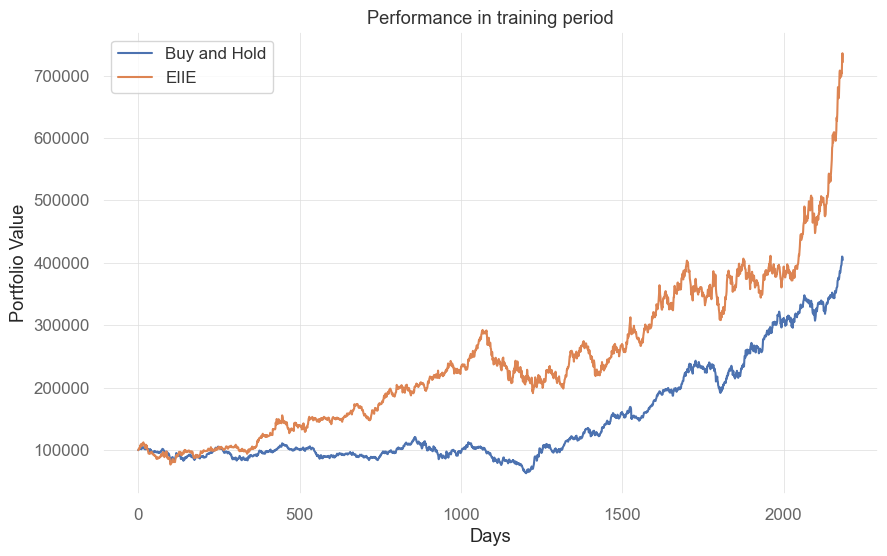

In [32]:
import matplotlib.pyplot as plt

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

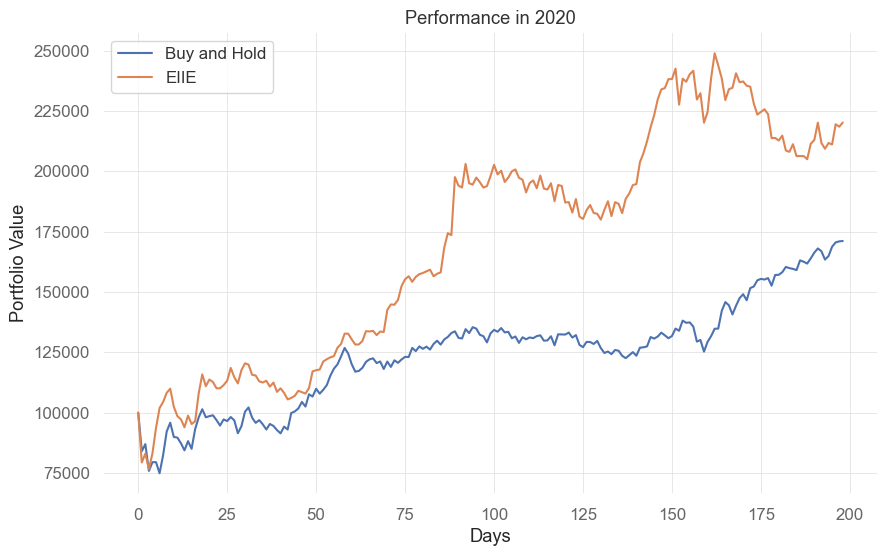

In [33]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

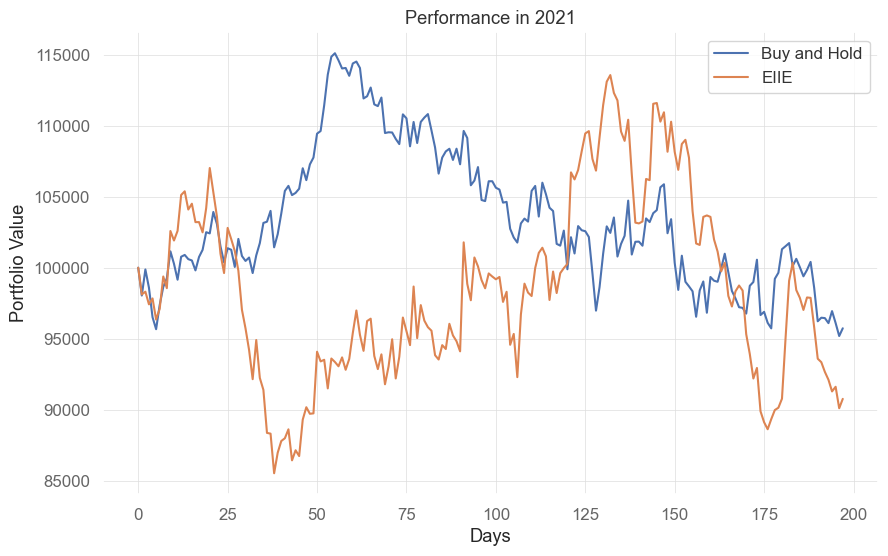

In [34]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

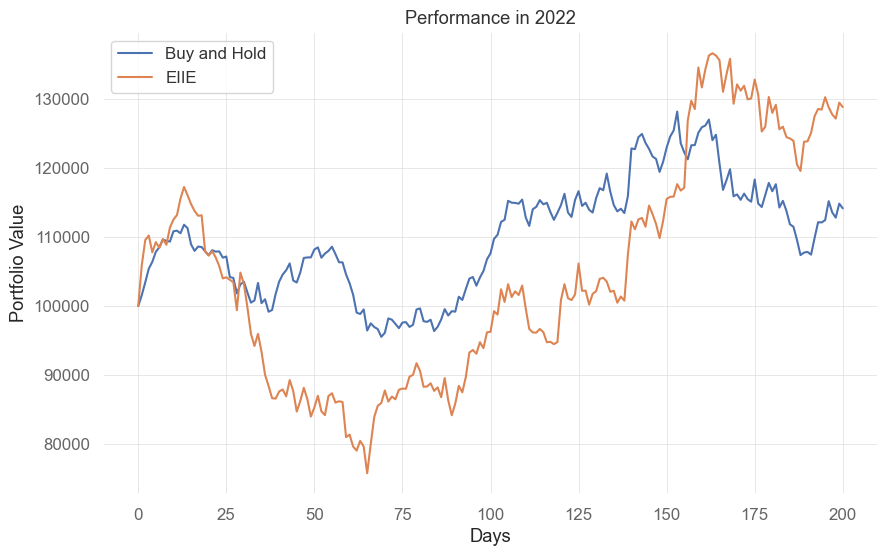

In [35]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()